In [1]:
import torch
import numpy as np
import h5py 
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 500
from torch.utils.data import DataLoader
import sys 
model_path = "..\\Models architecture"
sys.path.append(model_path)
torch.manual_seed(0)

# Importing the hyperparameters and the trained weights 

In [7]:
weights_path = "C:\\Users\\noedi\\Desktop\\Stage été 2022\\Code stage\\Vae Galaxies\\Data\\weights + losses\\galaxy_w_redshift\\cvae\\z32_beta0.1_weightscvae2.pt"
weights, hyperparameters = torch.load(weights_path)

batchsize = hyperparameters["batch size"]
z_dim = hyperparameters["z_dim"]
epochs = hyperparameters["epochs"]
lr = hyperparameters["learning rate"]
beta = hyperparameters["beta"]


In [3]:
data_deepfield = 'C:\\Users\\noedi\\Desktop\\Stage été 2022\\Code stage\\Vae Galaxies\\Data\\cosmos_23.5_128_augmented_denoised.h5' 
data_cosmic_survey = 'C:\\Users\\noedi\\Desktop\\Stage été 2022\\Code stage\\Vae Galaxies\\Data\\cosmos_25.2_all_with_zphot.h5'

In [4]:
class Hdf_dataset(torch.utils.data.Dataset):
    def __init__(self, file):
        self.file = file
        self.hdf = h5py.File(file, 'r')
        self.datasets = list(self.hdf.keys())

    def __len__(self):
        size = len(self.hdf[self.datasets[0]])
        return size

    def __getitem__(self, idx):
        # Cosmic survey dataset: galaxy images and redshifts
        if len(self.datasets) == 2:
            x = self.hdf[self.datasets[0]][idx]
            z = self.hdf[self.datasets[1]][idx]
            return x, z
        
        # Deepfield dataset: just galaxy images
        else:
            x = self.hdf[self.datasets[0]][idx]
            return x 

In [5]:
torch.manual_seed(0)
cosmic_survey_dataset = Hdf_dataset(data_cosmic_survey)
deepfield_dataset = Hdf_dataset(data_deepfield)

galaxy_loader = DataLoader(cosmic_survey_dataset, batch_size =  batchsize, shuffle = True ) # --> change the dataset according the model you want to try 

#galaxies = next(iter(galaxy_loader))       # for deepfield dataset
galaxies, zphot = next(iter(galaxy_loader)) # for cosmic survey dataset

## Defining the model and loading the weights 

In [8]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
# Importing model 
from cvae2 import VariationalAutoencoder

# Model parameters (nc = 1 for cvae2)
vae = VariationalAutoencoder(z_dim).to(device)

# Loading trained weights 
vae.load_state_dict(weights)

<All keys matched successfully>

## Plots

3 classes for the different types of plots (in the file Helper_reconstruct_generate_interpolate.py):
- `reconstruct(vae, hyperparameters)`: reconstruction galaxy images
- `generate(vae, hyperparameters)`: generation of galaxy images
- `interpolate(vae, hyperparameters)` : interpolation of one galaxy structure for different redshifts (only for the cosmic survey dataset)

In [10]:
from Helper_reconstruct_generate_interpolate import *

#### Reconstruction
Different methods for `reconstruct(vae, hyperparameters)`:
- `cvae(galaxies, zphot, colour='hot', num_ images = 10, title = False, figure_title = "Reconstruction cvae architecture")` (for cvae and cvae2)
- `fancy_cvae(galaxies, zphot, *args)`
- `vae158(galaxies, zphot, *args)` (for the cosmic survey dataset)
- `vae128(galaxies, *args)` (for the deep field dataset)

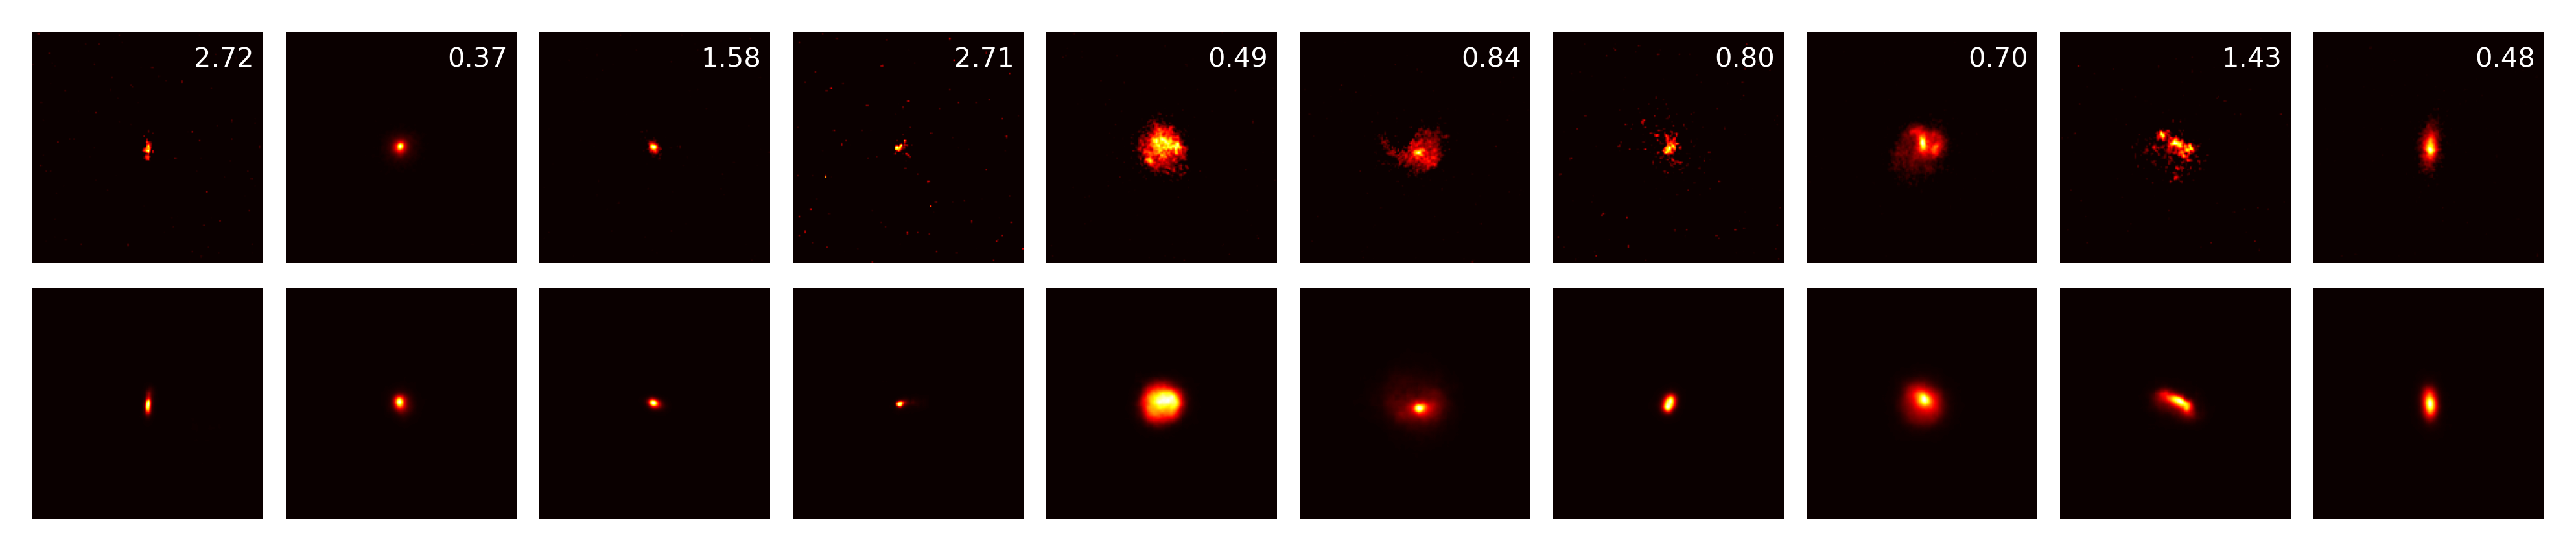

In [11]:
# default: figure_title = "Reconstruction {model} architecture"
torch.manual_seed(11)
reconstruct(vae, hyperparameters).cvae(galaxies, zphot, colour = 'hot', num_images = 10, title = False)
#file = "C:\\Users\\noedi\\Desktop\\Reconstruction_vae128_beta0.1.png"
#plt.savefig(file, transparent = True)

#### Generation
Different methods for `generate(vae, hyperparameters)`:
- `cvae(redshift_value, *args)`
- `cvae2(redshift_value, *args)`
- `fancy_cvae(redshift_value, *args)`
- `vae(*args)`

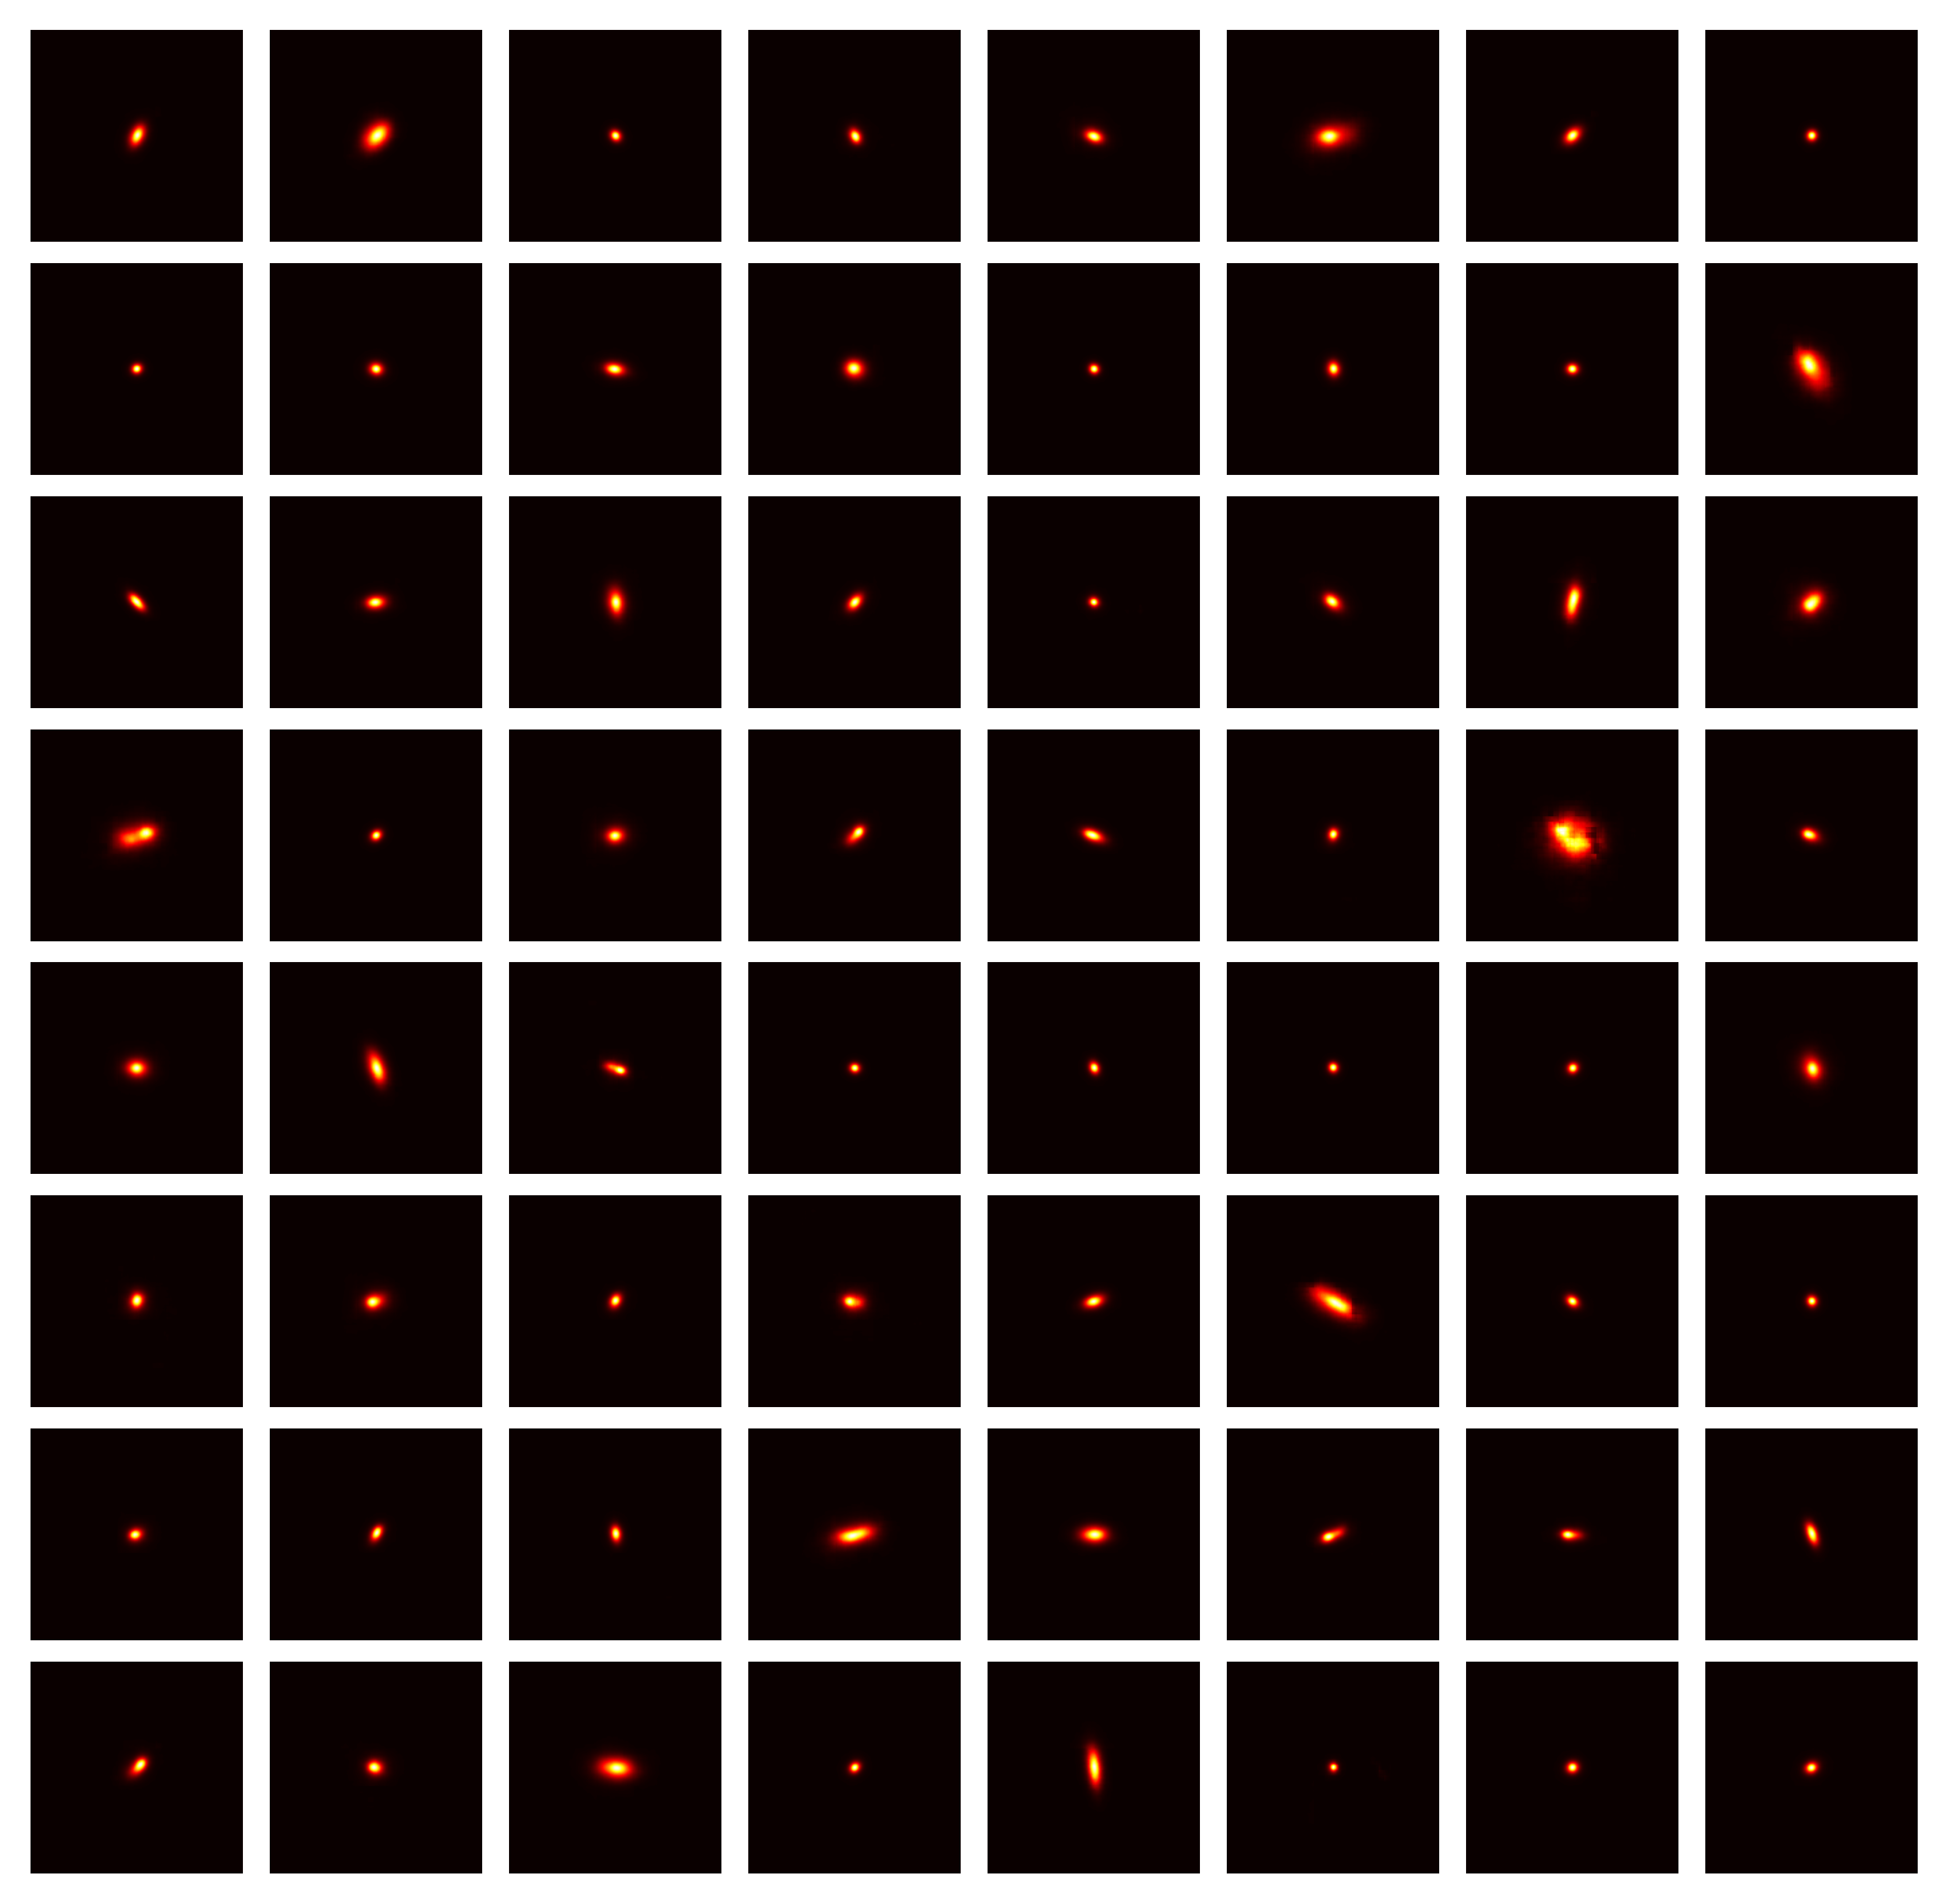

In [75]:
# default:title = figure_title = "Generation {model} architecture"
torch.manual_seed(2)
# redshift = 2.5
generate(vae, hyperparameters).vae(rows = 8, cols = 8, colour = 'hot', title = False) 
#file = "C:\\Users\\noedi\\Desktop\\Generation_vae158_beta1.png"
#plt.savefig(file, transparent = True)

#### Interpolation over the redshifts (for Conditional Vaes)
Different methods for `interpolate(vae, hyperparameters)`:
- `cvae(redshift_tensor, *args)` (seeds for some nice generated galaxy structure: 4, 5, 11, 14, 16)
- `cvae2(redshift_tensor, *args)` (seeds for some nice generated galaxy structure: 0, 1, 7, 22, 26, 27, 35 )
- `fancy_cvae(redshift_tensor, *args)` (seeds for some nice generated galaxy structure: 0, 10, 15, 16, 21, 25)

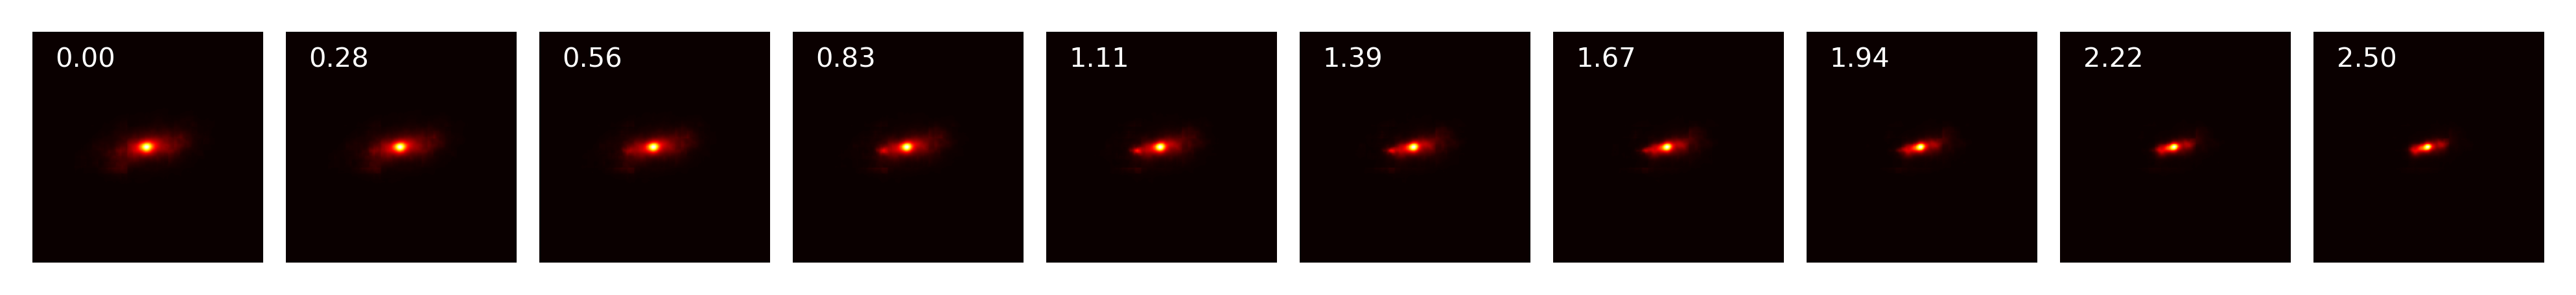

In [54]:
# Interpolation for the cvae models
torch.manual_seed(35)
num_images = 10
redshift = torch.linspace(0, 2.5, 10)

# Default figure_title = "Interpolation {model} architecture" 
interpolate(vae, hyperparameters).cvae2(redshift, cols = num_images, colour = 'hot', title = False) 